In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install geopandas
! pip install rasterio
! pip install rasterstats
! pip install --quiet contextily matplotlib
! pip install torch 
! pip install earthpy
! pip install gdal 
! pip install cupy-cuda111     #>=7.7.0,<8.0.0'
! pip install torchfcn
! pip install pyyaml h5py 
! pip install breizhcrops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 80.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 738.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━

In [3]:
import geopandas as gpd
import pandas as pd

import rasterio
from rasterio.plot import show

from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision

import tensorflow as tf
from tensorflow import keras

import breizhcrops

import numpy as np
import os
import glob
import math
from osgeo import gdal
from datetime import datetime
import PIL
import sys
import time
import seaborn as sn
from sklearn.metrics import f1_score , accuracy_score , precision_score, recall_score,label_ranking_average_precision_score,balanced_accuracy_score,average_precision_score,multilabel_confusion_matrix,cohen_kappa_score


# Load Dataset

In [4]:
class CropSegmentationDataset(torch.utils.data.Dataset):
  def __init__(self, df, is_traintestval,  validation_region=4, n_classes=9,transform=None, target_transform=None):
        self.dataset_df = df
        self.dataset_df = self.dataset_df.loc[self.dataset_df['Classcode'].isin(range(n_classes))]
        self.validation_region = validation_region
        self.transform = transform
        self.target_transform = target_transform   

        if is_traintestval == 'test':
          self.dataset_df = self.dataset_df[dataset_df["REGION"]==validation_region]
          self.values = self.dataset_df.iloc[:,9:].astype(float)
          self.labels = self.dataset_df["Classcode"].astype(float)

        if is_traintestval == 'train' or is_traintestval == 'validation':
          self.dataset_df = self.dataset_df[dataset_df["REGION"]!=validation_region]
          self.values = self.dataset_df.iloc[:,9:].astype(float)
          self.labels = self.dataset_df["Classcode"].astype(float)

          x_train, x_validation, y_train, y_validation = train_test_split(
              self.values, self.labels, test_size= 0.2, random_state=42)
          
          if is_traintestval == 'train':
              self.values = x_train
              self.labels = y_train
          if is_traintestval == 'validation':
              self.values = x_validation
              self.labels = y_validation

        #turn seperate bands into a input matrixes of 7 x the amount of bands
        valuelist = []
        timefr = 7
        bands = int(len(self.values.columns)/timefr)
  
        for i in range(len(self.values)):
            matrixdata = np.zeros((timefr,bands))
            for j in range(timefr):
              for k in range(bands):
                l = (j*bands)+k 
                matrixdata[j,k] = self.values.iloc[i,l]
            valuelist.append(matrixdata)

        self.valuelist = valuelist

  def __len__(self):
        return len(self.labels)

  def __getitem__(self, idx):
        values = self.valuelist[idx]
        label = self.labels.iloc[idx]
        values = torch.tensor(values).type(torch.float32)
        label = torch.tensor(label).type(torch.float32)
        label.type(torch.LongTensor)
        if self.transform:
            values = self.transform(values)
        if self.target_transform:
            label = self.target_transform(label)
        return values, label

In [5]:
load_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/Data/"
validation_region = 2
n_class = 9

#inputdataframe = "mean_df" 
#n_bands = 4

#inputdataframe = "meanmedian_df" 
#n_bands = 8

inputdataframe = "meanmedianpercentile_df" 
n_bands = 16


dataset_df = pd.read_csv(load_path + inputdataframe + ".csv")

dataset_train =       CropSegmentationDataset(dataset_df, 'train',      validation_region ,n_classes=n_class)
dataset_validation =  CropSegmentationDataset(dataset_df, 'validation', validation_region ,n_classes=n_class)
dataset_test =        CropSegmentationDataset(dataset_df, 'test',       validation_region ,n_classes=n_class)

# dataloader training
dataloader_training = torch.utils.data.DataLoader(dataset=dataset_train,
                                 batch_size=8,
                                 shuffle=True)
# dataloader validation
dataloader_validation = torch.utils.data.DataLoader(dataset=dataset_validation,
                                   batch_size=8,
                                   shuffle=True)
# dataloader validation
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test,
                                   batch_size=8,
                                   shuffle=True)

<ipython-input-4-e381568da728>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.dataset_df = self.dataset_df[dataset_df["REGION"]!=validation_region]
<ipython-input-4-e381568da728>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.dataset_df = self.dataset_df[dataset_df["REGION"]==validation_region]


# Training

In [ ]:
# train


In [6]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = torch.device(device)
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.step(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.step()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            y = y.type(torch.LongTensor)
            y = torch.nan_to_num(y)
            x = torch.nan_to_num(x)
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad() # zerograd the parameters

            out = self.model(input)# one forward pass

            loss = self.criterion(out, target)
            loss = torch.nan_to_num(loss)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            y = y.type(torch.LongTensor)
            y = torch.nan_to_num(y)
            x = torch.nan_to_num(x)
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))


In [42]:
# model

#just for clarity, but these variables are defined earlier
n_class = n_class
n_channel = n_bands

dropout = 0.2

#model = breizhcrops.models.LSTM(input_dim=n_channel, num_classes=n_class, hidden_dims=128, num_layers=4, dropout=dropout, bidirectional=True, use_layernorm=True)
#model = breizhcrops.models.MSResNet(input_dim=n_channel, layers=[1, 1, 1, 1], num_classes=n_class, hidden_dims=32)
model = breizhcrops.models.OmniScaleCNN(input_dim= n_channel, num_classes=n_class,sequencelength=45 ,paramenter_number_of_layer_list=[8 * 128, 5 * 128 * 256 + 2 * 256 * 128], few_shot=False)
#model = breizhcrops.models.PETransformerModel(input_dim=n_channel, num_classes=n_class, d_model=64, n_head=2, n_layers=5,d_inner=128, activation="relu", dropout=dropout, max_len=200)
#model = breizhcrops.models.StarRNN( input_dim= n_channel, num_classes= n_class, hidden_dims=128, num_layers=3, dropout= dropout, bidirectional=False,use_batchnorm=False, use_layernorm=True, device=torch.device("cuda"))



#model = breizhcrops.models.InceptionTime(num_classes=n_class, input_dim=n_channel ,num_layers=6, hidden_dims=128,use_bias=False, use_residual= True, device=torch.device("cuda")) #NOTWORKING
#model = breizhcrops.models.TempCNN( input_dim= n_channel, num_classes= n_class, sequencelength=45, kernel_size=7, hidden_dims=128, dropout=dropout) #NOTWORKING
#model = breizhcrops.models.TransformerModel( input_dim=n_channel, num_classes=n_channel, d_model=64, n_head=2, n_layers=5,d_inner=128, activation="relu", dropout=dropout) #not working #CUDA ISSUE


model = model.cuda()
#model = model.to(torch.device('cuda:0'))

# criterion
# NEEDS TO BE CHANGED FOR THE ONES USED IN THE PAPER
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , 'min')

# trainer
n_epochs = 50
trainer = Trainer(model=model,
                  device='cuda',
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler= lr_scheduler,
                  epochs=n_epochs,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()



Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

Training:   0%|          | 0/1773 [00:00<?, ?it/s]

Validation:   0%|          | 0/444 [00:00<?, ?it/s]

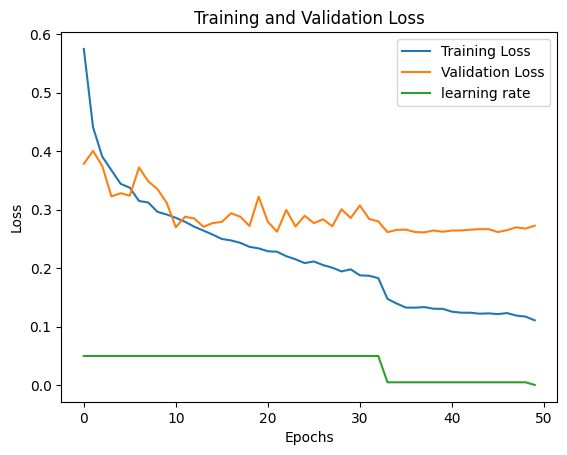

In [43]:
#training output visualisation


epochs = range(n_epochs)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.plot(epochs, lr_rates, label='learning rate')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Save Model

In [44]:
from datetime import date
today = datetime.now()
# dd/mm/YY/Hour/Minutes
d1 = today.strftime("_%d%m%H%M")



notes = "_50epochs_realtest_9classmeanmedianpercentiles"

#save the entire model to drive
model_name = model.__class__.__name__ + d1
path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/models/9_15_20_class/" + model_name + notes + ".pt"
torch.save(model,path) 

In [45]:
#print list of available models 
model_list = os.listdir('/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/models/9_15_20_class')
print(len(model_list))
model_list


15


['LSTM_27051147_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'LSTM_27051200_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'LSTM_27051216_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'LSTM_27051305_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'LSTM_27051320_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'MSResNet_27051350_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'MSResNet_27051420_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'MSResNet_27051454_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'MSResNet_27051545_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'MSResNet_31051301_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'OmniScaleCNN_31051323_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'OmniScaleCNN_31051349_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'OmniScaleCNN_31051412_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'OmniScaleCNN_31051446_50epochs_realtest_9classmeanmedianpercentiles.pt',
 'OmniScal

In [ ]:
#load a trained model
model_list = os.listdir('/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/models/9class_mmp_5times')
latest = len(model_list)




#model_name = model_list[latest]
model_name = 'MSResNet_24051457_50epochs_realtest_20classmeanmedianpercentiles.pt'

model_path = "/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/models/9class_mmp_5times/"+ model_name  #path for Unet3d

model = torch.load(model_path)
model.eval()

MSResNet(
  (conv1): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer3x3_1): Sequential(
    (0): BasicBlock3x3(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(32, 32, kernel_size=(1,), stride=(2,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer3x3_2): Sequential(
    (0): Basic

# Model Evaluation

In [46]:
class Evaluate:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 validation_dataloader: torch.utils.data.Dataset = None,
                 savepath = "",
                 n_classes: int = 9
                 ):
      self.n_classes = n_classes
      self.savepath = savepath
      self.model = model
      self.dataloader_validation = validation_dataloader
      self.model.eval()
      self.y_pred = []
      self.y_true = []
      self.df_out = pd.DataFrame()
      self.metric_list = []
      self.metric_list_names = []
      self.recall_list = []
      self.precision_list =[]
      self.f1_list = []
      self.label_list = []
      for i in range(self.n_classes):
        self.label_list.append(i)
     

    def predict_output(self):
      pred = []
      true = [] 
      # iterate over test data
      for inputs, labels in self.dataloader_validation:
              output = self.model(inputs.cuda()) # Feed Network

              output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
              pred.extend(output) # Save Prediction
              
              labels = labels.data.cpu().numpy()
              true.extend(labels) # Save Truth
      self.y_pred = pred
      self.y_true = true

    def create_conf_matrix(self):
      true = np.array(self.y_true).astype(int)
      pred = np.array(self.y_pred).astype(int)

      true = true.reshape((true.shape[0], -1))
      pred = pred.reshape((pred.shape[0], -1))

      cf_matrix = confusion_matrix(true.reshape(-1), pred.reshape(-1))
      df_cm = pd.DataFrame(cf_matrix)

      return df_cm

    def show_confusion_matrix(self):
      plt.figure(figsize = (12,7))
      sn.heatmap(self.create_conf_matrix(), annot=True)
      plt.savefig('output.png')

    def get_output(self):
      print("output matrix")
      return self.df_out

    def calculate_metrics(self): #calculates the metrics that are needed
      true = self.y_true
      pred = self.y_pred

      self.recall_list = recall_score(true, pred,average=None)
      self.precision_list = precision_score(true, pred,average=None)
      self.f1_list = f1_score(true, pred,average=None,zero_division=0)

      self.metric_list_names = [
          'F1 score weighted:',
          'F1 score micro:',
          'F1 score macro:',
          'average accuracy:',
          'overall accuracy:',
          'kappa score:'
      ]

      self.metric_list = [
              f1_score(true, pred,labels=self.label_list,average='weighted',zero_division=0),
              f1_score(true, pred,labels=self.label_list,average='micro',zero_division=0),
              f1_score(true, pred,labels=self.label_list,average='macro',zero_division=0),
              balanced_accuracy_score(true, pred), #average accuracy
              accuracy_score(true, pred, normalize=False).sum()/len(true), #overall accuracy
              cohen_kappa_score(true,pred)
      ]

      #if length of classes changes the length of the list should change aswell
      for i in range(self.n_classes-len(self.metric_list)):
        self.metric_list.append('')
      for i in range(self.n_classes-len(self.metric_list_names)):
        self.metric_list_names.append('')

    
    def evaluate(self):
      self.predict_output()
      confusionmatrix = self.create_conf_matrix()
      self.calculate_metrics()
      df_out = confusionmatrix
      df_out.insert(self.n_classes,"recall",self.recall_list,False)
      df_out.insert(self.n_classes+1,"precision",self.precision_list,False)
      df_out.insert(self.n_classes+2,"f1_score",self.f1_list,False)
      df_out.insert(self.n_classes+3,"metrics names",self.metric_list_names,False)
      df_out.insert(self.n_classes+4,"metrics values",self.metric_list,False)
      self.df_out = df_out
      return self.df_out, self.create_conf_matrix()

    def save_output(self):
      today = datetime.now()
      model_name = model.__class__.__name__ + today.strftime("_%d%m%H%M") +'.csv'
      path = self.savepath  + model_name
      self.df_out.to_csv(path)


Next block evaluates the model and saves the output to the specified path

In [47]:
path = '/content/drive/My Drive/INF-Msc_Thesis/Msc-Thesis-Crop-Type-Mapping/model_output/9_15_20_class/' 

#initialize evaluation
evaluate = Evaluate(
    model = model,
    device = 'cuda',
    validation_dataloader = dataloader_test,
    savepath = path,
    n_classes = n_class
)

#get the output matrix and confusion matrix from evaluation
df_out , df_cm = evaluate.evaluate()

#save the output for later use
evaluate.save_output()

In [48]:
#shows the confusion matrix and saved output matrix
df = evaluate.get_output()
df.iloc[:,:29]

output matrix


,0,1,2,3,4,5,6,7,8,recall,precision,f1_score,metrics names,metrics values
0,2773,108,0,2,5,1,0,0,1,0.959516,0.907098,0.932571,F1 score weighted:,0.899697
1,272,204,2,4,3,2,2,3,5,0.410463,0.633540,0.498168,F1 score micro:,0.906751
2,1,0,41,0,0,2,0,0,2,0.891304,0.803922,0.845361,F1 score macro:,0.881066
3,0,0,1,230,2,0,4,0,0,0.970464,0.942623,0.956341,average accuracy:,0.881854
4,9,5,1,1,527,0,4,1,2,0.958182,0.958182,0.958182,overall accuracy:,0.906751
5,0,1,0,1,5,75,3,0,0,0.882353,0.862069,0.872093,kappa score:,0.858317
6,0,3,3,4,6,3,582,2,0,0.965174,0.973244,0.969192,,
7,0,0,0,0,0,2,2,205,0,0.980861,0.940367,0.960187,,
8,2,1,3,2,2,2,1,7,225,0.918367,0.957447,0.937500,,
